# Controls Challenge Submission

**Importing Required Libraries**

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
from tinyphysics_modified import TinyPhysicsModel_Modified, TinyPhysicsSimulator_Modified, CONTROL_START_IDX
from controllers import SimpleController, BaseController
import io
from tinyphysics_modified_2 import TinyPhysicsModel, TinyPhysicsSimulator
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import clear_output
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Actor Class**

In [14]:
class Actor(nn.Module):
    
    def __init__(self, max_action=2):
        super(Actor, self).__init__()
        self.max_action = max_action
        self.l1 = nn.Linear(7, 300)
        self.l2 = nn.Linear(300,200)
        self.l3 = nn.Linear(200,200)
        self.l4 = nn.Linear(200, 1)

    def forward(self, s):
        s = F.relu(self.l1(s))
        s = F.relu(self.l2(s))
        s = F.relu(self.l3(s))
        a = self.max_action * torch.tanh(self.l4(s))  # [-max,max]
        return a

**Critic Class**

In [15]:
class Critic(nn.Module):  
    def __init__(self):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(8, 300)
        self.l2 = nn.Linear(300,200)
        self.l3 = nn.Linear(200,200)
        self.l4 = nn.Linear(200, 1)

    def forward(self, s, a):
        q = F.relu(self.l1(torch.cat([s, a], 1)))
        q = F.relu(self.l2(q))
        q = F.relu(self.l3(q))
        q = self.l4(q)
        return q

**Replay Buffer**

In [4]:
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim):
        self.max_size = int(200000)
        self.count = 0
        self.size = 0
        self.s = np.zeros((self.max_size, state_dim))
        self.a = np.zeros((self.max_size, action_dim))
        self.r = np.zeros((self.max_size, 1))
        self.s_ = np.zeros((self.max_size, state_dim))
        self.dw = np.zeros((self.max_size, 1))

    def store(self, s, a, r, s_, dw):
        self.s[self.count] = s
        self.a[self.count] = a
        self.r[self.count] = r
        self.s_[self.count] = s_
        self.dw[self.count] = dw
        self.count = (self.count + 1) % self.max_size  # When the 'count' reaches max_size, it will be reset to 0.
        self.size = min(self.size + 1, self.max_size)  # Record the number of  transitions

    def sample(self, batch_size):
        index = np.random.choice(self.size, size=batch_size)  # Randomly sampling
        batch_s = torch.tensor(self.s[index], dtype=torch.float)
        batch_a = torch.tensor(self.a[index], dtype=torch.float)
        batch_r = torch.tensor(self.r[index], dtype=torch.float)
        batch_s_ = torch.tensor(self.s_[index], dtype=torch.float)
        batch_dw = torch.tensor(self.dw[index], dtype=torch.float)

        return batch_s, batch_a, batch_r, batch_s_, batch_dw

**DDPG Agent Class**

In [5]:
class DDPG(object):
    def __init__(self, state_dim, action_dim):
        
        self.hidden_width = 256
        self.batch_size = 128
        self.GAMMA = 0.99
        self.TAU = 0.001
        self.lr = 0.001

        self.actor = Actor().to(DEVICE)
        self.actor_target = copy.deepcopy(self.actor).to(DEVICE)
        self.critic = Critic().to(DEVICE)
        self.critic_target = copy.deepcopy(self.critic).to(DEVICE)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=0.0001)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=0.001)

        self.MseLoss = nn.MSELoss().to(DEVICE)

    def save_checkpoint(self, i):
        actor_path = "checkpoints/actor_checkpoint_" + str(i) + ".pth"
        critic_path =  "checkpoints/critic_checkpoint_" + str(i) + ".pth"
        torch.save(self.actor.state_dict(), actor_path)
        torch.save(self.critic.state_dict(), critic_path)
        print(f"Saved checkpoints to {actor_path} and {critic_path}")

    def load_checkpoint(self, actor_path, critic_path):
        self.actor.load_state_dict(torch.load(actor_path))
        self.critic.load_state_dict(torch.load(critic_path))
        self.actor_target = copy.deepcopy(self.actor).to(DEVICE)
        self.critic_target = copy.deepcopy(self.critic).to(DEVICE)
        print(f"Loaded checkpoints from {actor_path} and {critic_path}")

    def choose_action(self, s):
        s = torch.unsqueeze(s.clone().detach().float(), 0).to(DEVICE)
        a = self.actor(s).data.cpu().numpy().flatten()
        return a

    def decrease_learning_rate(self):
        # Reduce learning rate by 10%
        self.lr  = self.lr / 10
        for param_group in self.actor_optimizer.param_groups:
            param_group['lr'] = self.lr
        for param_group in self.critic_optimizer.param_groups:
            param_group['lr'] = self.lr

        print(f"Updated learning rate to {self.lr}")

    def learn(self, relay_buffer):

        batch_s, batch_a, batch_r, batch_s_, batch_dw = relay_buffer.sample(self.batch_size)  
        batch_s = batch_s.to(DEVICE)
        batch_r = batch_r.to(DEVICE)
        batch_s_ = batch_s_.to(DEVICE)
        batch_dw = batch_dw.to(DEVICE)
        batch_a = batch_a.to(DEVICE)

        with torch.no_grad(): 
            Q_ = self.critic_target(batch_s_, self.actor_target(batch_s_)).to(DEVICE)
            target_Q = batch_r + self.GAMMA * (1 - batch_dw) * Q_

        current_Q = self.critic(batch_s, batch_a)
        critic_loss = F.mse_loss(current_Q,target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        for params in self.critic.parameters():
            params.requires_grad = False

        actor_loss = -self.critic(batch_s, self.actor(batch_s)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        for params in self.critic.parameters():
            params.requires_grad = True

        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.TAU * param.data + (1 - self.TAU) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.TAU * param.data + (1 - self.TAU) * target_param.data)

**Policy Evaluation**

In [6]:
def evaluate_policy(agent):
    
    sns.set_theme()
    class MyController(BaseController):
      last_road = -99
      def update(self, target_lataccel, current_lataccel, state, last_action):
        roll_lataccel, v_ego, a_ego = state
        state = torch.tensor([v_ego, a_ego, roll_lataccel, target_lataccel, current_lataccel, target_lataccel-current_lataccel, last_action])
            
        action = agent.choose_action(state)[0]
          
        return action
    
    def plot_rollout(sim):
      fig, ax = plt.subplots(figsize=(10, 5))
      ax.plot(sim.target_lataccel_history, label="Target Lateral Acceleration", alpha=0.5)
      ax.plot(sim.current_lataccel_history, label="Actual Lateral Acceleration", alpha=0.5)
      ax.legend()
      ax.set_xlabel("Step")
      ax.set_ylabel("Lateral Acceleration")
      ax.set_title("Rollout")
      plt.show()
    
    model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
    controller = MyController()
    
    sim = TinyPhysicsSimulator(model, "./data/00000.csv", controller=controller, debug=False)
    
    print(sim.rollout())
    
    plot_rollout(sim)

    model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
    controller = MyController()
    
    sim = TinyPhysicsSimulator(model, "./data/00002.csv", controller=controller, debug=False)
    
    print(sim.rollout())
    
    plot_rollout(sim)


    model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
    controller = MyController()
    
    sim = TinyPhysicsSimulator(model, "./data/00010.csv", controller=controller, debug=False)
    
    print(sim.rollout())
    
    plot_rollout(sim)
    times = 20  
    evaluate_reward = 0
    for _ in range(times):
        done = False
        random_integer = torch.randint(0, 19999, (1,)).item()
        env = Environment(2,random_integer)
        episode_reward = 0
        while not done:
            state = env.get_state()
            action = agent.choose_action(state)[0]
            actual, reward, done = env.step(action)
            episode_reward += reward
            
        evaluate_reward += env.sim.compute_cost()["total_cost"]

    return float(evaluate_reward / float(times))

def count_steps(filename):
     with open(filename, 'r') as file:
        return sum(1 for line in file)

def generate_filename(index):
    return f"./data/{index:05}.csv"

**Environment Class**

In [7]:
class Environment:

    def __init__(self, max_action, start_index):
        self.max_action = max_action
        self.last_actual = None
        self.num_steps = 0
        self.current_file_index = start_index
        self.max_file_index = 19999
        self.prepare()

    def prepare(self):
        file_name = generate_filename(self.current_file_index)
        self.num_steps = count_steps(file_name)-1
        self.controller = SimpleController()
        self.model = TinyPhysicsModel_Modified("./models/tinyphysics.onnx", debug=False)
        self.sim = TinyPhysicsSimulator_Modified(self.model, file_name, controller=self.controller, debug=False)
        self.last_actual = None

    def next_episode(self):
        self.current_file_index = torch.randint(0, 20000, (1,)).item()
        self.prepare()

    def random_action(self):
        random_action = -2.0 + 4.0 * torch.rand(1).item()
        return random_action
    
    def get_state(self):
        state_object, target =  self.sim.get_state_target(self.sim.step_idx)
        roll_lataccel, v_ego, a_ego = state_object
        last_action = self.sim.action_history[len(self.sim.action_history)-1]
        actual = self.sim.current_lataccel_history[len(self.sim.current_lataccel_history)-1]
        return torch.tensor([v_ego, a_ego, roll_lataccel, target, actual, target-actual, last_action])
    
    def step(self, action):
        target = self.get_state()[3]
        self.sim.step(action)
        actual = self.sim.current_lataccel_history[len(self.sim.current_lataccel_history)-1]
        last_actual = self.sim.current_lataccel_history[len(self.sim.current_lataccel_history)-2]
        lateral_cost = 100.0*(actual-target)*(actual-target)
        jerk_cost = 100.0*(actual-last_actual)*(actual-last_actual)/0.1
        delta_action = self.sim.action_history[len( self.sim.action_history)-1]- self.sim.action_history[len( self.sim.action_history)-2]
        action_cost = 0.0
        action_cost = delta_action*delta_action
        cost = (5.0*lateral_cost + 3.0*jerk_cost) + 10*action_cost
        reward = -1.0*float(cost)
        done = False
        if self.sim.step_idx==self.num_steps-1:
            done = True
        return actual,float(reward), done

**Training Config**

In [8]:
state_dim = 7
action_dim = 1
max_action = 2
agent = DDPG(state_dim, action_dim)
replay_buffer = ReplayBuffer(state_dim, action_dim)

noise_std = 0.5 * max_action  
max_train_steps = 10000000000  # Maximum number of training steps
random_steps = 2000  # Take the random actions in the beginning for the better exploration
update_freq = 50  # Take 50 steps,then update the networks 50 times
evaluate_freq = 1e5  # Evaluate the policy every 'evaluate_freq' steps
evaluate_num = 0  # Record the number of evaluations
evaluate_rewards = []  # Record the rewards during the evaluating
total_steps = 0  # Record the total steps during the training
finished = 0
starting_episode = 300
env = Environment(2,0)
state = env.get_state()

**Load Checkpoint**

In [9]:
# agent.load_checkpoint("backup_checkpoints/actor_checkpoint_0.pth","backup_checkpoints/critic_checkpoint_0.pth")

**Training**

In [ ]:
lowest_eval = 10000000

while True:
    done = False
    while not done:
        state = env.get_state().to(DEVICE)
        explore = torch.rand(1).item()
        if replay_buffer.size < 200000:
            action = env.random_action()
        elif explore > 0.50:
            action = env.random_action()
        else:
            action = agent.choose_action(state)
            action = (action + np.random.normal(0, 0.01, size=action_dim)).clip(-max_action, max_action) # Add Gaussian noise to actions for exploration
            action = action[0]
       
        actual, reward, done = env.step(action)
        next_state = env.get_state().to(DEVICE)
        replay_buffer.store(state.cpu(), action, reward, next_state.cpu(), done)

        if done:
            env.next_episode()
            finished += 1

        if done and finished%3 == 0 and replay_buffer.size >= 10:
            for _ in range(10):
                agent.learn(replay_buffer)
        
        if replay_buffer.size >= 10 and finished%50 == 0:
            clear_output(wait=True)
            finished += 1
            evaluate_num += 1
            evaluate_reward = evaluate_policy(agent)
            if evaluate_reward<lowest_eval:
                lowest_eval = evaluate_reward
                agent.save_checkpoint(lowest_eval)
            evaluate_rewards.append(evaluate_reward)
           
            print(type(evaluate_num))
            print(evaluate_num)
            print("evaluate_num:{} \t evaluate_reward:{}".format(evaluate_num, evaluate_reward))
            plt.plot(evaluate_rewards)
            plt.ylim([0,1500])

        total_steps += 1

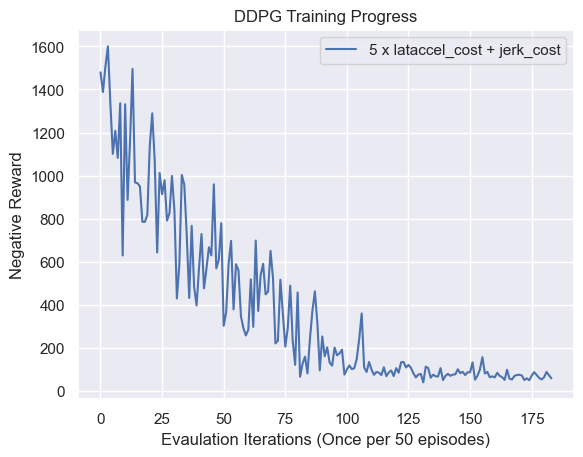

In [12]:
cost = np.load("submission_files/cost.npy")
cost = cost[60:]
plt.plot(cost)
plt.title("DDPG Training Progress")
plt.xlabel("Evaulation Iterations (Once per 50 episodes)")
plt.ylabel("Negative Reward")
plt.legend(["5 x lataccel_cost + jerk_cost"])
plt.grid(True)